In [1]:
import pandas as pd
from connections import AWS

$\textbf{Epidemiology: Clinical Comparison}$

Compares model predictions across height-, mass-, and pitch count-match controls.

In [2]:
""" INITIALIZE AWS CONNECTION """
aws = AWS()
aws.connect()

[AWS]: Port 5433 is free.
[AWS]: Connected to RDS endpoint.


$\textbf{Data Loading}$

In [ ]:
# load cohort of matches
cohort_matches = aws.load_s3_object('epidemiology/cohorts/injured/pitcher_info/matches_0825.csv')

# join injury metadata to filter out non-tissue injuries
cohort_metadata = aws.load_s3_object('epidemiology/cohorts/injured/pitcher_info/pitchers_0825.csv')
cohort_metadata['season'] = cohort_metadata['injury_date'].str[0:4].astype(int)
injury_info = cohort_metadata.merge(cohort_matches, right_on=['mlbamid_injured', 'season'], left_on=['mlbamid', 'season'], how='inner')[['mlbamid', 'injury_type']]

# filter out non-tissue injuries
    # --> 209 injuries remaining
valid_injuries = [
    'tommy_john_surgery', 
    'elbow_surgery_(internal_brace)', 
    'elbow_surgery', 
    'arthroscopic_elbow_surgery', 
    'elbow_surgery_(ucl)', 
    'tommy_john_surgery_(internal_brace)'
]
valid_injury_info = injury_info[injury_info['injury_type'].isin(valid_injuries)].reset_index(drop=True)
cohort_matches_final = cohort_matches[cohort_matches['mlbamid_injured'].isin(valid_injury_info['mlbamid'])].reset_index(drop=True)

# upload final cohort matches to S3
aws.upload_to_s3(cohort_matches_final, 'epidemiology/ml/datasets/full/cohort_matches_final.csv')

In [7]:
# load model predictions
model_preds = aws.load_s3_object('epidemiology/ml/datasets/preds/model_application.csv')
model_preds.drop_duplicates(subset=['pitcher', 'game_date', 'pred_peak_evt'], inplace=True)

# add season to model predictions
model_preds['season'] = model_preds['game_date'].str[:4].astype(int)
model_preds.sort_values(by=['pitcher', 'game_date', 'pitch_id'], inplace=True)

$\textbf{Data Annotations \& Aggregates}$

__Pitch-Level Annotations__

Metadata: 
- `outing_number` (_int_): Specifies the outing number in the season 
- `last_outing_before_injury` (_bool_): Whether or not this was the last outing before a pitcher injury --> can be used for injury prediction
- `outings_until_injury` (_int_): Count of how many outings remain until an injury is observed (if applicable)

Workload: 
- `within_outing_pitch_count` (_int_): Total within outing pitch count for a pitcher
- `within_outing_cumulative_evt_workload` (_float_): Total within outing workload for a pitcher, accumulated at the pitch-level; this is the rolling sum of normalized torques

In [8]:
""" PITCH LEVEL """
# add outing_number column
model_preds['outing_number'] = model_preds.groupby(['pitcher', 'season'])['game_date'].rank(method='dense').astype(int)

# add within outing workload metrics (pitches thrown, evt workload)
model_preds['within_outing_pitch_count'] = model_preds.groupby(['pitcher', 'season', 'outing_number'])['pitch_id'].cumcount() + 1
model_preds['within_outing_cumulative_evt_workload'] = model_preds.groupby(['pitcher', 'season', 'outing_number'])['pred_peak_evt_normalized'].cumsum()

# add outing_before_injury column
last_outings = model_preds[model_preds['injured_cohort_pitcher'] == 1].groupby(['pitcher', 'season'])['game_date'].max().reset_index()
last_outings['last_outing_before_injury'] = 1

# apply merges
model_preds_annotated = model_preds.merge(last_outings, on=['pitcher', 'season', 'game_date'], how='left')
model_preds_annotated['last_outing_before_injury'].fillna(0, inplace=True)
model_preds_annotated.drop_duplicates(inplace=True)

__Outing-Level Aggregates__

Total Workload Metrics:
- `outing_total_pitch_count` (_int_): Total pitches thrown by a pitcher during an outing
- `outing_total_evt_workload` (_float_): Total within outing EVT workload for a pitcher, summed over all pitch-level
- `outing_avg_evt_workload` (_float_): Average per-pitch EVT workload within an outing
- `outing_median_evt_workload` (_float_): Median per-pitch EVT workload within an outing

In [9]:
""" OUTING LEVEL """
# create a copy for aggregation + store metadata
outing_metadata = model_preds_annotated[['pitcher', 'season', 'game_date', 'injured_cohort_pitcher', 'last_outing_before_injury']].drop_duplicates()

# total workload metrics
    # NOTE: avg & median workload help distinguish from pitch counts --> how "intense" was each pitch that was thrown
outing_metrics = model_preds_annotated.groupby(['pitcher', 'season', 'game_date', 'outing_number', 'pitcher_days_since_prev_game',]).agg(
    outing_total_pitch_count=('pitch_id', 'count'),
    outing_total_evt_workload=('within_outing_cumulative_evt_workload', 'max'),
    outing_avg_evt_workload=('pred_peak_evt_normalized', 'mean'),
    outing_median_evt_workload=('pred_peak_evt_normalized', 'median'),
).reset_index()


$\textbf{Gather Model Predictions}$

In [117]:
""" MATCHED COMPARISONS """
#   iterate through matched rows
#       for each match, get all model predictions for injured pitcher, non-injured pitcher (sort & store)
matched_preds = {}
for _, match in cohort_matches_final.sort_values('season').iterrows():

    # get metadata
    season = match['season']
    inj_id = match['mlbamid_injured']
    noninj_id = match['mlbamid_noninjured']

    # get window of injured pitches
    inj_first_pitch = model_preds_annotated[model_preds_annotated['pitcher'] == inj_id]['game_date'].min()
    inj_last_pitch = model_preds_annotated[model_preds_annotated['pitcher'] == inj_id]['game_date'].max()

    # filter model predictions, aggregates to date range of injured pitcher
    model_preds_match = model_preds_annotated[
        (model_preds_annotated['game_date'] >= inj_first_pitch) & 
        (model_preds_annotated['game_date'] <= inj_last_pitch) & 
        (model_preds_annotated['season'] == season) & 
        (model_preds_annotated['pitcher'].isin([inj_id, noninj_id]))
    ].copy()
    outing_metrics_match = outing_metrics[
        (outing_metrics['game_date'] >= inj_first_pitch) & 
        (outing_metrics['game_date'] <= inj_last_pitch) & 
        (outing_metrics['season'] == season) & 
        (outing_metrics['pitcher'].isin([inj_id, noninj_id]))
    ].copy()
    outing_metadata_match = outing_metadata[
        (outing_metadata['game_date'] >= inj_first_pitch) & 
        (outing_metadata['game_date'] <= inj_last_pitch) & 
        (outing_metadata['season'] == season) & 
        (outing_metadata['pitcher'].isin([inj_id, noninj_id]))
    ].copy()

    # get model predictions for injured pitcher
    inj_preds = model_preds_match[model_preds_match['pitcher'] == inj_id]
    noninj_preds = model_preds_match[model_preds_match['pitcher'] == noninj_id]

    # store metadata & pitch/outing-level data in dictionary
    matched_preds[inj_id] = {
        'injured': {
            'metadata': outing_metadata_match[outing_metadata_match['pitcher'] == inj_id].copy(),
            'pitch_level': inj_preds,
            'outing_level': outing_metrics_match[outing_metrics_match['pitcher'] == inj_id].copy()
        },
        'noninjured': {
            'metadata': outing_metadata_match[outing_metadata_match['pitcher'] == noninj_id].copy(),
            'pitch_level': noninj_preds,
            'outing_level': outing_metrics_match[outing_metrics_match['pitcher'] == noninj_id].copy()
        }
    }

$\textbf{Group Comparisons}$

- __Group comparison__ (i.e, inj. vs noninj. means)
- __Pairwise comparison__ (i.e., inj. - noninj. compared to 0)

In [118]:
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

In [119]:
# setup comparisons
all_pitch_data = []                     # master list of all data (--> group comparison)
all_diffs = {
    'vals': [],
    'inj_grt_than_noninj': [],
} 


# iterate through matches
for inj_id, match in matched_preds.items():
    # pitch data --> add to master list
    pitch_data = pd.concat([
        match['injured']['pitch_level'].assign(injured=1),
        match['noninjured']['pitch_level'].assign(injured=0)
    ]).reset_index(drop=True)
    all_pitch_data.append(pitch_data)

    # setup pairwaise comparison
    inj_mean = match['injured']['pitch_level']['pred_peak_evt'].mean()
    noninj_mean = match['noninjured']['pitch_level']['pred_peak_evt'].mean()
    
    # compute difference
    diff = inj_mean - noninj_mean
    all_diffs['vals'].append(diff)
    all_diffs['inj_grt_than_noninj'].append(int(diff > 0))

# concatenate all pitch data together
all_pitch_df = pd.concat(all_pitch_data).reset_index(drop=True)

In [121]:
""" TEST 1: Group Comparison """
# t-test: compare means of injured vs non-injured groups
    # NOTE: significant (--> injured sig. higher than non-injured)
t_stat, p_value = ttest_ind(
    all_pitch_df[all_pitch_df['injured'] == 1]['pred_peak_evt'], 
    all_pitch_df[all_pitch_df['injured'] == 0]['pred_peak_evt'], 
    alternative='greater',
    equal_var=False
) 
print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.3f}")

""" TEST 2: Pairwise Comparison """
# t-test: compare differences to 0
    # NOTE: not significant (--> not enough evidence to say injured match avgs are greater than non-injured)
diffs = np.array(all_diffs['vals'])
t_stat, p_value = ttest_ind(diffs, np.zeros_like(diffs), alternative='greater', equal_var=False)
print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.3f}")

""" TEST 3: Proportion of Injured > Non-Injured """
# proportion test: compare proportion of matches where injured avg > non-injured avg
    # NOTE: not significant (obvious, proportion was < 0.5)
num_injured_exceed = sum(all_diffs['inj_grt_than_noninj'])
num_noninjured_exceed = len(all_diffs['inj_grt_than_noninj']) - num_injured_exceed
stat, pval = proportions_ztest(num_injured_exceed, num_noninjured_exceed, value=len(all_diffs['inj_grt_than_noninj']), alternative='larger')
print(f"Z-statistic: {stat:.3f}, p-value: {pval:.3f}")

T-statistic: 17.790, p-value: 0.000
T-statistic: -0.165, p-value: 0.565
Z-statistic: -4563.868, p-value: 1.000


In [126]:
np.array(all_diffs['vals']).mean()

-0.15589148464910318

In [113]:
# close AWS connection
aws.close()

[AWS]: Database connection closed.
[AWS]: SSH tunnel stopped.


$\textbf{TBD: Preliminary Clinical Recommendations?}$

Used to inform modeling approach. Includes the following for each pair:
- `total_evt_workload_by_days_rest`: Median "Total EVT Workload" for given days of rest (only considers 1-7 days rest) --> comparing injured/noninjured gives preliminary workload recommendations
- Median & Total EVT Workload from 1/2/3 outing(s) prior to injury --> preliminary ACWR insights
- Average Pitch-Level EVT Workload for the entire season

In [753]:
import pickle
import numpy as np

In [1003]:
# get median total evt workload by days rest for given outing metrics
def get_evt_by_days_rest(data: pd.DataFrame) -> tuple[dict, dict]:
    """ Returns dictionary of median total EVT workload by days rest for given `DataFrame` of outing metrics. """
    return dict(data['outing_level'].groupby('pitcher_days_since_prev_game')['outing_total_evt_workload'].median()), dict(data['outing_level'].groupby('pitcher_days_since_prev_game')['outing_median_evt_workload'].median())

# create the skeleton for a clinical comparisons dictionary
def create_clinical_comparisons_dict() -> dict:
    """ Returns a dictionary with keys for clinical comparisons. """
    return {
        
        'total_evt_workload_by_days_rest': {
            'injured': {
                1: [],
                2: [],
                3: [],
                4: [],
                5: [],
                6: [],
                7: [],
            },
            'noninjured': {
                1: [],
                2: [],
                3: [],
                4: [],
                5: [],
                6: [],
                7: [],
            }
        },

        'median_evt_workload_by_days_rest': {
            'injured': {
                1: [],
                2: [],
                3: [],
                4: [],
                5: [],
                6: [],
                7: [],
            },
            'noninjured': {
                1: [],
                2: [],
                3: [],
                4: [],
                5: [],
                6: [],
                7: [],
            }
        },
       
        'total_workload_prior_to_injury': {
            'injured': {
                1: [],
                2: [],
                3: [],
            },
            'noninjured': {
                1: [],
                2: [],
                3: [],
            }
        },

        'median_workload_prior_to_injury': {
            'injured': {
                1: [],
                2: [],
                3: [],
            },
            'noninjured': {
                1: [],
                2: [],
                3: [],
            }
        },

        'season_avg_evt_workload': {
            'injured': [],
            'noninjured': []
        }

    }

def get_prior_outings_workload(
        data: pd.DataFrame,
        n_outings_prior_to_inj: int = 3
):
    """ Returns a dictionary of total & median EVT workload for `n_outings_prior_to_inj` prior to injury from given `DataFrame` of outing metrics. """
    # initialize storage
    workload_data = {n+1: {} for n in range(0, n_outings_prior_to_inj)}
    
    # iterate through prior outings (if > 1)
    if n_outings_prior_to_inj > 1:
        for i in range(1, n_outings_prior_to_inj + 1):
                outing_data = data.sort_values(by=['game_date']).reset_index(drop=True).iloc[-i:, :]
                workload_data[i] = {
                     'total': outing_data['outing_total_evt_workload'].values[0],
                     'median': outing_data['outing_median_evt_workload'].values[0],
                }

        return workload_data
    
    else:   
        outing_data = data.sort_values(by=['game_date']).reset_index(drop=True).iloc[-n_outings_prior_to_inj:, :]
        workload_data[1] = {
                        'total': outing_data['outing_total_evt_workload'].values[0],
                        'median': outing_data['outing_median_evt_workload'].values[0],
                        }
        
        return workload_data
    
def update_clinical_comparisons(
        clinical_comparisons: dict,
        inj_dict: dict,
        noninj_dict: dict,
):
    """ 
    Updates the clinical comparisons dictionary with data from injured & non-injured pitchers. 
    
    Args:
        clinical_comparisons (dict): Dictionary to update with clinical comparisons data.
        inj_dict (dict): Dictionary containing data for the injured pitcher.
        noninj_dict (dict): Dictionary containing data for the non-injured pitcher.
    
    Returns:
        None: The function updates the `clinical_comparisons` dictionary in place.
    """
    
    # total evt workload by days rest
    inj_total_rest, inj_median_rest = get_evt_by_days_rest(inj_dict)
    noninj_total_rest, noninj_median_rest = get_evt_by_days_rest(noninj_dict)
    
    # iterate through days rest (1-7) & update dictionary
    for days_rest in inj_total_rest.keys():
        if days_rest in range(1, 8):
            clinical_comparisons['total_evt_workload_by_days_rest']['injured'][days_rest].append(inj_total_rest[days_rest])
            clinical_comparisons['median_evt_workload_by_days_rest']['injured'][days_rest].append(inj_median_rest[days_rest])
    for days_rest in noninj_total_rest.keys():
        if days_rest in range(1, 8):
            clinical_comparisons['total_evt_workload_by_days_rest']['noninjured'][days_rest].append(noninj_total_rest[days_rest])
            clinical_comparisons['median_evt_workload_by_days_rest']['noninjured'][days_rest].append(noninj_median_rest[days_rest])

    # median/total evt workload from 1/2/3 outings prior to injury
        # --> preliminary ACWR insights; these may not be super insightful yet
    inj_prior_outings_workload = get_prior_outings_workload(inj_dict['outing_level'], n_outings_prior_to_inj=3)
    noninj_prior_outings_workload = get_prior_outings_workload(noninj_dict['outing_level'], n_outings_prior_to_inj=3)
    
    # update clinical comparisons with prior outings workload
    for outing_num in inj_prior_outings_workload.keys():
        clinical_comparisons['total_workload_prior_to_injury']['injured'][outing_num].append(inj_prior_outings_workload[outing_num]['total'])
        clinical_comparisons['median_workload_prior_to_injury']['injured'][outing_num].append(inj_prior_outings_workload[outing_num]['median'])
    for outing_num in noninj_prior_outings_workload.keys():
        clinical_comparisons['total_workload_prior_to_injury']['noninjured'][outing_num].append(noninj_prior_outings_workload[outing_num]['total'])
        clinical_comparisons['median_workload_prior_to_injury']['noninjured'][outing_num].append(noninj_prior_outings_workload[outing_num]['median'])

    # season-long median pitch-level evt workload
    clinical_comparisons['season_avg_evt_workload']['injured'].append(inj_dict['pitch_level']['pred_peak_evt_normalized'].mean())
    clinical_comparisons['season_avg_evt_workload']['noninjured'].append(noninj_dict['pitch_level']['pred_peak_evt_normalized'].mean())

# NOTE: this function essentially just separates injured & noninjured updates -- could easily consolidate & nest
def update_clinical_comparisons_by_role(
        clinical_comparisons: dict,
        pitcher_dict: dict,
        role: str,
        injured_status: str
):
    """ 
    Updates the clinical comparisons dictionary with data for a specific pitcher role.
    
    Args:
        clinical_comparisons (dict): Dictionary to update with clinical comparisons data.
        pitcher_dict (dict): Dictionary containing data for the pitcher.
        role (str): The role of the pitcher (e.g., 'starter', 'reliever').
        injured_status (str): The status of the pitcher ('injured' or 'noninjured') used to update the dictionary.
    
    Returns:
        None: The function updates the `clinical_comparisons` dictionary in place.
    """
    # total evt workload by days rest
    total_evt_by_days_rest, median_evt_by_days_rest = get_evt_by_days_rest(pitcher_dict)
    
    # iterate through days rest (1-7) & update dictionary
    for days_rest in total_evt_by_days_rest.keys():
        if days_rest in range(1, 8):
            clinical_comparisons[role]['total_evt_workload_by_days_rest'][injured_status][days_rest].append(total_evt_by_days_rest[days_rest])
            clinical_comparisons[role]['median_evt_workload_by_days_rest'][injured_status][days_rest].append(median_evt_by_days_rest[days_rest])

    # median/total evt workload from 1/2/3 outings prior to injury
        # --> preliminary ACWR insights; these may not be super insightful yet
    prior_outings_workload = get_prior_outings_workload(pitcher_dict['outing_level'], n_outings_prior_to_inj=3)
    
    # update clinical comparisons with prior outings workload
    for outing_num in prior_outings_workload.keys():
        clinical_comparisons[role]['total_workload_prior_to_injury'][injured_status][outing_num].append(prior_outings_workload[outing_num]['total'])
        clinical_comparisons[role]['median_workload_prior_to_injury'][injured_status][outing_num].append(prior_outings_workload[outing_num]['median'])

    # season-long median pitch-level evt workload
    clinical_comparisons[role]['season_avg_evt_workload'][injured_status].append(pitcher_dict['pitch_level']['pred_peak_evt_normalized'].mean())


In [1004]:
# initialize clincial comparison (overall & by pitcher type)
clinical_comparisons = create_clinical_comparisons_dict()
clinical_comparisons_by_role = {
    'starter': create_clinical_comparisons_dict(),
    'reliever': create_clinical_comparisons_dict(), 
}

# set primary role counts
primary_role_counts = {
    'injured': {
        'starter': 0,
        'reliever': 0
    },
    'noninjured': {
        'starter': 0,
        'reliever': 0
    }
}

# iterate through matched pairs
for inj_id, matched_data in matched_preds.items():
    # get injured & noninjured data
    inj_dict = matched_data['injured']
    noninj_dict = matched_data['noninjured']

    # check for sufficient outings (3)
    if len(inj_dict['outing_level']) < 3 or len(noninj_dict['outing_level']) < 3:
        continue

    # apply starter (75+) or reliever label to outings
        # NOTE: somewhat of a limitation due to simplifying here
    inj_dict['outing_level']['pitcher_role'] = inj_dict['outing_level'].apply(lambda x: 'starter' if x['outing_total_pitch_count'] >= 75 else 'reliever', axis=1)
    noninj_dict['outing_level']['pitcher_role'] = noninj_dict['outing_level'].apply(lambda x: 'starter' if x['outing_total_pitch_count'] >= 75 else 'reliever', axis=1)

    """ OVERALL CLINICAL COMPARISONS """
    # update overall clinical comparisons
        # NOTE: this is done in place
    update_clinical_comparisons(clinical_comparisons, inj_dict, noninj_dict)

    """ CLINICAL COMPARISONS BY PITCHER ROLE """
    # get primary roles
        # NOTE: this is fine for aggregate, DL model will capture more nuance
    inj_primary_role = inj_dict['outing_level']['pitcher_role'].mode()[0]
    noninj_primary_role = noninj_dict['outing_level']['pitcher_role'].mode()[0]

    # update primary role counts
    primary_role_counts['injured'][inj_primary_role] += 1
    primary_role_counts['noninjured'][noninj_primary_role] += 1

    # update clinical comparisons by role
    update_clinical_comparisons_by_role(clinical_comparisons_by_role, inj_dict, inj_primary_role, 'injured')
    update_clinical_comparisons_by_role(clinical_comparisons_by_role, noninj_dict, noninj_primary_role, 'noninjured')

In [1005]:
# save to disc
with open('storage/clinical_comparisons.pkl', 'wb') as f:
    pickle.dump({
        'clinical_comparisons': clinical_comparisons,
        'clinical_comparisons_by_role': clinical_comparisons_by_role,
        'primary_role_counts': primary_role_counts
    }, f)

$\textbf{Aggregate Clinical Data}$

In [1076]:
# total workload by days rest (non-injured)
total_workload_by_days_rest = {
    'starter_mean': {key: np.mean(val) for key, val in clinical_comparisons_by_role['starter']['total_evt_workload_by_days_rest']['noninjured'].items()},
    'starter_sd': {key: (1.96 * np.std(val) / 3) for key, val in clinical_comparisons_by_role['starter']['total_evt_workload_by_days_rest']['noninjured'].items()},
    'reliever_mean': {key: np.mean(val) for key, val in clinical_comparisons_by_role['reliever']['total_evt_workload_by_days_rest']['noninjured'].items()},
    'reliever_sd': {key: (1.96 * np.std(val) / 3) for key, val in clinical_comparisons_by_role['reliever']['total_evt_workload_by_days_rest']['noninjured'].items()}
}

# add some noise to 1/2 day SD for plotting purposes
total_workload_by_days_rest['starter_sd'][1] = 0.5
total_workload_by_days_rest['starter_sd'][2] = 0.75

$\textit{Plots}$

Create non-injured plots, compare to proposal --> then check how many injured pitchers adhered?

In [1077]:
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

In [1078]:
def generate_workload_plot(
        workload_data: dict,
        role: str
) -> plt.Figure:
    """ 
    Generates a workload plot based on the provided workload data. Fits a univariate spline to the data for smooth visualization.

    Args:
        workload_data (dict): A dictionary containing workload data with keys 'starter_mean', 'starter_sd', 'reliever_mean', and 'reliever_sd'.
        role (str): The role of the pitcher ('starter' or 'reliever') to plot.

    Returns:
        plt.Figure: The generated workload plot figure.
    """

    plt.figure(figsize=(15, 10))
    
    # create x values (days rest)
    x = np.array(list(workload_data['starter_mean'].keys()))[:-1]

    # create y values
    y = np.array(list(workload_data[f'{role}_mean'].values()))[:-1]
    y_err = np.array(list(workload_data[f'{role}_sd'].values()))[:-1]

    # insert 0,0 point
    x = np.insert(x, 0, 0)
    y = np.insert(y, 0, 0)
    y_err = np.insert(y_err, 0, 0)

    # create spline for smooth curve
    spline = UnivariateSpline(x, y, s=0)
    x_fit = np.linspace(x.min(), x.max(), 100)
    plt.plot(x_fit, spline(x_fit), color='black', label='')

    # create error bar splines
    spline_upper = UnivariateSpline(x, y + y_err, s=0)
    spline_lower = UnivariateSpline(x, y - y_err, s=0)
    plt.plot(x_fit, spline_upper(x_fit), color='gray', linestyle='--', alpha=0.5, label='Aggressive Workload (+ 1.96 SD)')
    plt.plot(x_fit, spline_lower(x_fit), color='gray', linestyle='--', alpha=0.5, label='Conservative Workload (- 1.96 SD)')

    # add error bars (dashed)
    plt.errorbar(x, y, yerr=y_err, fmt='o', color='blue', ecolor='lightblue', elinewidth=2, capsize=4, label='Workload ± 95% CI')

    # plot details
    plt.xticks(fontsize=13.5)
    plt.yticks(fontsize=13.5)
    plt.xlabel('Days Rest', fontdict={'size': 15})
    plt.ylabel('Total EVT Workload', fontdict={'size': 15})
    plt.title(f'{role.capitalize()} Workload Allotment by Days Rest\n', fontdict={'size': 18, 'weight': 'bold'})

    # hide upper and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # finalize plot
    plt.legend(fontsize=12)
    plt.grid(visible=True, linestyle='--', alpha=0.5)

    return plt.gca()


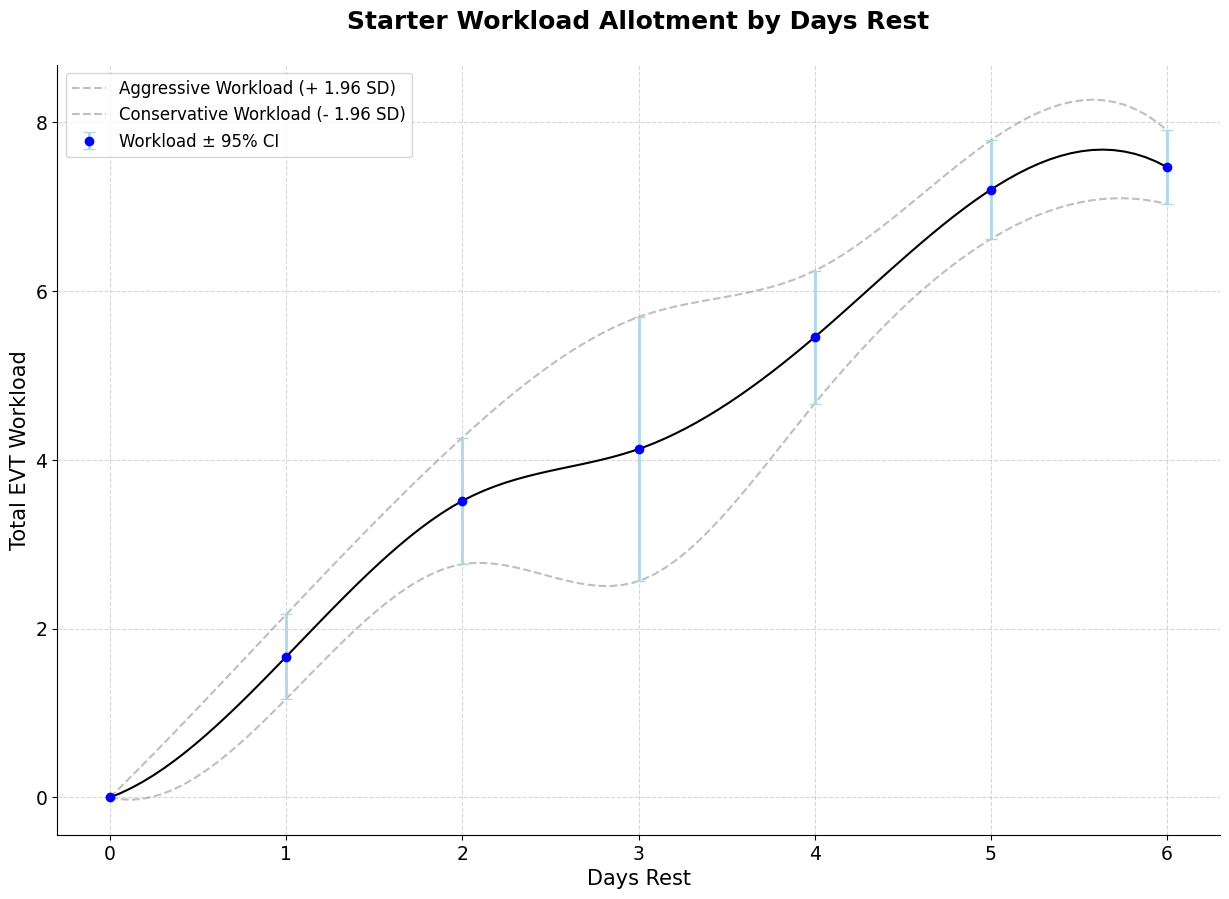

In [1079]:
# extract days rest and starter mean workload
starter_plot = generate_workload_plot(total_workload_by_days_rest, role='starter')

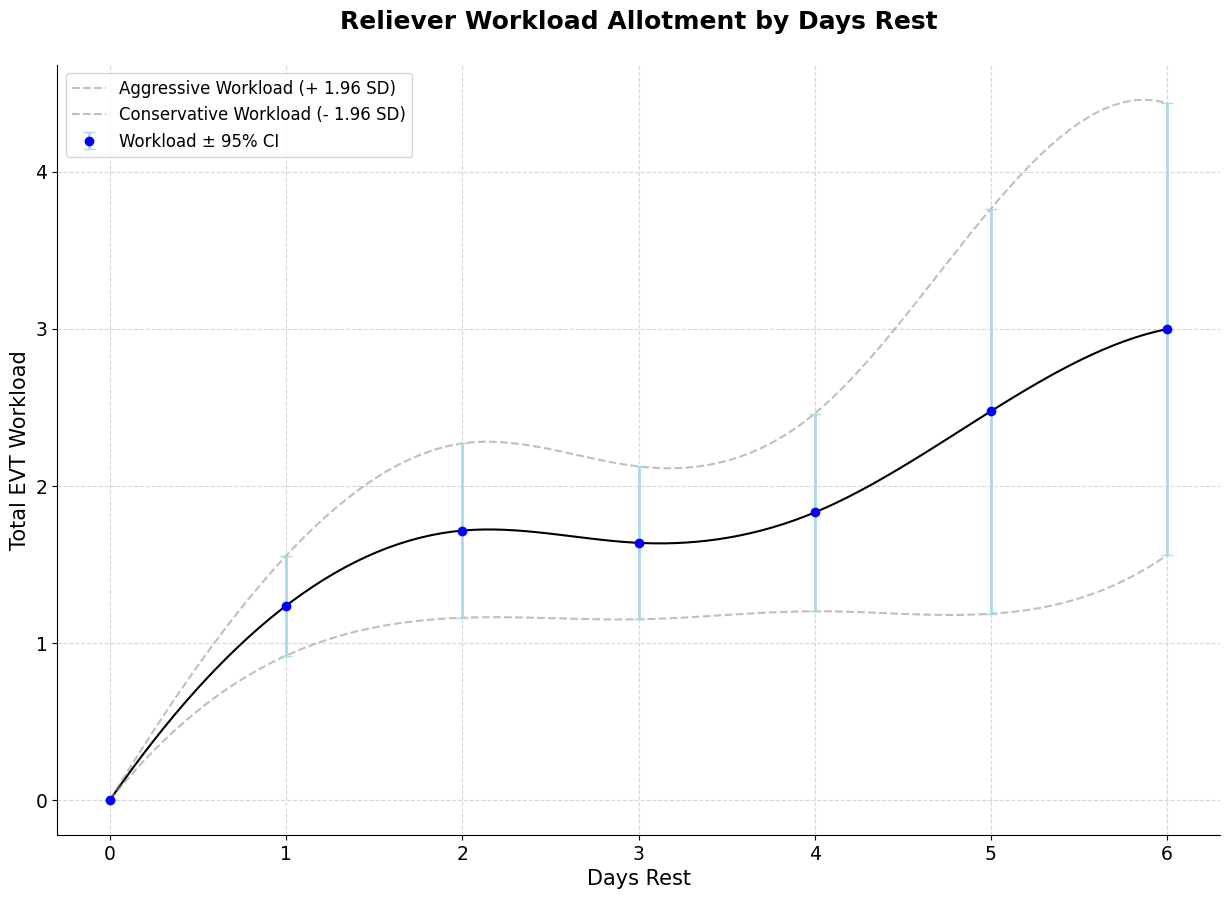

In [1080]:
# extract days rest and starter mean workload
reliever_plot = generate_workload_plot(total_workload_by_days_rest, role='reliever')

$\textit{Statistical Tests}$

Note that no differences are statistically significant. 

In [1081]:
from scipy.stats import ttest_ind

In [1082]:
# example: compare total workload prior to injury for relievers (injured vs noninjured, 1 outing prior)
injured = clinical_comparisons_by_role['starter']['season_avg_evt_workload']['injured']
noninjured = clinical_comparisons_by_role['starter']['season_avg_evt_workload']['noninjured']
t_stat, p_value = ttest_ind(injured, noninjured, equal_var=False)  # Welch's t-test

print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.3f}")

T-statistic: 0.492, p-value: 0.624


$\textbf{Clinical Tests}$

In [1083]:
from typing import Union

In [1193]:
def compute_upper_bounds(
        summary: dict,
        role: str,
        as_dataframe: bool = False
) -> Union[dict, pd.DataFrame]:
    """ 
    Computes upper bounds for the given role based on total workload by days rest. 

    Args:
        summary (dict): A dictionary containing the summary statistics for the role.
        role (str): The role for which to compute upper bounds ('starter' or 'reliever').
        as_dataframe (bool): If True, returns a DataFrame; otherwise, returns a dictionary.

    Returns:
        Union[dict, pd.DataFrame]: A dictionary or DataFrame containing the upper bounds for the specified role.
    
    """
    if as_dataframe:
        bounds_dict = {k: v[0] + v[1] for k, v in dict(zip(summary[f'{role}_mean'].keys(), zip(summary[f'{role}_mean'].values(), summary[f'{role}_sd'].values()))).items()}
        bounds_df = pd.DataFrame.from_dict(bounds_dict, orient='index', columns=['noninj_upper_bound']).reset_index().rename(columns={'index': 'pitcher_days_since_prev_game'})
        bounds_df.insert(1, 'pitcher_role', role)

        return bounds_df
    
    else:
        return {k: v[0] + v[1] for k, v in dict(zip(summary[f'{role}_mean'].keys(), zip(summary[f'{role}_mean'].values(), summary[f'{role}_sd'].values()))).items()}
    
def get_average_workload(
        summary: dict,
        role: str,
        as_dataframe: bool = False
) -> Union[dict, pd.DataFrame]:
    """ 
    Computes average EVT workload the given role based on total workload by days rest. 

    Args:
        summary (dict): A dictionary containing the summary statistics for the role.
        role (str): The role for which to compute upper bounds ('starter' or 'reliever').
        as_dataframe (bool): If True, returns a DataFrame; otherwise, returns a dictionary.

    Returns:
        Union[dict, pd.DataFrame]: A dictionary or DataFrame containing the upper bounds for the specified role.
    
    """
    if as_dataframe:
        bounds_dict = {k: v for k, v in dict(zip(summary[f'{role}_mean'].keys(), summary[f'{role}_mean'].values())).items()}
        bounds_df = pd.DataFrame.from_dict(bounds_dict, orient='index', columns=['noninj_avg_workload']).reset_index().rename(columns={'index': 'pitcher_days_since_prev_game'})
        bounds_df.insert(1, 'pitcher_role', role)

        return bounds_df
    
    else:
        return {k: v for k, v in dict(zip(summary[f'{role}_mean'].keys(), summary[f'{role}_mean'].values())).items()}

def generate_workload_plot(
        workload_data: dict,
        role: str,
        red_outings: pd.DataFrame = None,
        yellow_outings: pd.DataFrame = None,
        green_outings: pd.DataFrame = None,
        error_bars: bool = True,
        title: str = ''
) -> plt.Figure:
    """ 
    Generates a workload plot based on the provided workload data. Fits a univariate spline to the data for smooth visualization.

    Args:
        workload_data (dict): A dictionary containing workload data with keys 'starter_mean', 'starter_sd', 'reliever_mean', and 'reliever_sd'.
        role (str): The role of the pitcher ('starter' or 'reliever') to plot.
        red_outings (pd.DataFrame, optional): DataFrame containing outings that are considered "red" (high workload).
        yellow_outings (pd.DataFrame, optional): DataFrame containing outings that are considered "yellow" (moderate workload).
        green_outings (pd.DataFrame, optional): DataFrame containing outings that are considered "green" (low workload).
        error_bars (bool, optional): Whether to include error bars in the plot. Defaults to True.
        title (str, optional): Title for the plot. Defaults to an empty string.

    Returns:
        plt.Figure: The generated workload plot figure.
    """

    plt.figure(figsize=(15, 10))
    
    # create x values (days rest)
    x = np.array(list(workload_data['starter_mean'].keys()))[:-1]

    # create y values
    y = np.array(list(workload_data[f'{role}_mean'].values()))[:-1]
    y_err = np.array(list(workload_data[f'{role}_sd'].values()))[:-1]

    # insert 0,0 point
    x = np.insert(x, 0, 0)
    y = np.insert(y, 0, 0)
    y_err = np.insert(y_err, 0, 0)

    # create spline for smooth curve
    spline = UnivariateSpline(x, y, s=0)
    x_fit = np.linspace(x.min(), x.max(), 100)
    plt.plot(x_fit, spline(x_fit), color='black', label='Mean Non-Injured Workload')

    # create error bar splines
    spline_upper = UnivariateSpline(x, y + y_err, s=0)
    spline_lower = UnivariateSpline(x, y - y_err, s=0)
    plt.plot(x_fit, spline_upper(x_fit), color='gray', linestyle='--', alpha=0.5, label='Aggressive Workload (+ 1.96 SD)')
    plt.plot(x_fit, spline_lower(x_fit), color='gray', linestyle='--', alpha=0.5, label='Conservative Workload (- 1.96 SD)')

    # add error bars (dashed)
    if error_bars:
        plt.errorbar(x, y, yerr=y_err, fmt='o', color='blue', ecolor='lightblue', elinewidth=2, capsize=4, label='Workload ± 95% CI')

    # plot details
    plt.xticks(fontsize=13.5)
    plt.yticks(fontsize=13.5)
    plt.xlabel('Days Rest', fontdict={'size': 15})
    plt.ylabel('Total EVT Workload', fontdict={'size': 15})
    plt.title(f'{title}\n', fontdict={'size': 18, 'weight': 'bold'})

    # hide upper and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # OPT: add color-coded outings
    if red_outings is not None:
        plt.scatter(red_outings['pitcher_days_since_prev_game'], red_outings['outing_total_evt_workload'], color='red', label='Red Outings (High Workload)', alpha=0.6, edgecolor='red', s=10)
    if yellow_outings is not None:
        plt.scatter(yellow_outings['pitcher_days_since_prev_game'], yellow_outings['outing_total_evt_workload'], color='orange', label='Yellow Outings (Moderate Workload)', alpha=0.6, edgecolor='orange', s=10)
    if green_outings is not None:
        plt.scatter(green_outings['pitcher_days_since_prev_game'], green_outings['outing_total_evt_workload'], color='green', label='Green Outings (Low Workload)', alpha=0.6, edgecolor='green', s=10)

    # finalize plot
    plt.legend(fontsize=12)
    plt.grid(visible=True, linestyle='--', alpha=0.5)

    return plt.gca()


In [ ]:
# TODO: compute upper bounds, determine how many injured pitchers adhered to these guidelines
    # 1-2-3 outings prior to injury?
    # for each pitcher, what % of outings adhered (within matched cohort)?

In [1176]:
# assign starter/reliever roles based on total pitches thrown
outing_metrics_clinical = outing_metrics[outing_metrics['pitcher'].isin(cohort_matches_final['mlbamid_injured'])].copy()
outing_metrics_clinical['pitcher_role'] = outing_metrics_clinical.apply(lambda x: 'starter' if x['outing_total_pitch_count'] >= 75 else 'reliever', axis=1)

""" ADD WORKLOAD UPPER BOUNDS """
# compute upper bounds for starters and relievers
    # then merge together w/ suffixes
starter_upper_bounds = compute_upper_bounds(total_workload_by_days_rest, role='starter', as_dataframe=True)
reliever_upper_bounds = compute_upper_bounds(total_workload_by_days_rest, role='reliever', as_dataframe=True)
upper_bounds = pd.concat([starter_upper_bounds, reliever_upper_bounds], ignore_index=True)

# merge upper bounds with outing metrics
outing_metrics_clinical_bounds = outing_metrics_clinical.merge(upper_bounds, on=['pitcher_days_since_prev_game', 'pitcher_role'], how='left').dropna(subset=['noninj_upper_bound']).reset_index(drop=True)

""" ADD WORKLOAD AVERAGES """
# compute and stack average workloads by days rest
starter_averages = get_average_workload(total_workload_by_days_rest, role='starter', as_dataframe=True)
reliever_averages = get_average_workload(total_workload_by_days_rest, role='reliever', as_dataframe=True)
average_workloads = pd.concat([starter_averages, reliever_averages], ignore_index=True)

# merge average workloads with outing metrics
outing_metrics_clinical_bounds = outing_metrics_clinical_bounds.merge(average_workloads, on=['pitcher_days_since_prev_game', 'pitcher_role'], how='left').dropna(subset=['noninj_avg_workload']).reset_index(drop=True)

In [1177]:
# store outings by "color"
    # red: exceed upper bound
    # yellow: above mean, below upper bound
    # green: below mean
red_outings = {
    'starter': outing_metrics_clinical_bounds[
        (outing_metrics_clinical_bounds['outing_total_evt_workload'] > outing_metrics_clinical_bounds['noninj_upper_bound']) & 
        (outing_metrics_clinical_bounds['pitcher_role'] == 'starter') & 
        (outing_metrics_clinical_bounds['pitcher_days_since_prev_game'] <= 6)
    ],
    'reliever': outing_metrics_clinical_bounds[
        (outing_metrics_clinical_bounds['outing_total_evt_workload'] > outing_metrics_clinical_bounds['noninj_upper_bound']) & 
        (outing_metrics_clinical_bounds['pitcher_role'] == 'reliever') & 
        (outing_metrics_clinical_bounds['pitcher_days_since_prev_game'] <= 6)
    ]
}
yellow_outings = {
    'starter': outing_metrics_clinical_bounds[
        (outing_metrics_clinical_bounds['outing_total_evt_workload'] > outing_metrics_clinical_bounds['noninj_avg_workload']) & 
        (outing_metrics_clinical_bounds['outing_total_evt_workload'] <= outing_metrics_clinical_bounds['noninj_upper_bound']) & 
        (outing_metrics_clinical_bounds['pitcher_role'] == 'starter') & 
        (outing_metrics_clinical_bounds['pitcher_days_since_prev_game'] <= 6)
    ],
    'reliever': outing_metrics_clinical_bounds[
        (outing_metrics_clinical_bounds['outing_total_evt_workload'] > outing_metrics_clinical_bounds['noninj_avg_workload']) & 
        (outing_metrics_clinical_bounds['outing_total_evt_workload'] <= outing_metrics_clinical_bounds['noninj_upper_bound']) & 
        (outing_metrics_clinical_bounds['pitcher_role'] == 'reliever') & 
        (outing_metrics_clinical_bounds['pitcher_days_since_prev_game'] <= 6)
    ]
}
green_outings = {
    'starter': outing_metrics_clinical_bounds[
        (outing_metrics_clinical_bounds['outing_total_evt_workload'] <= outing_metrics_clinical_bounds['noninj_avg_workload']) & 
        (outing_metrics_clinical_bounds['pitcher_role'] == 'starter') & 
        (outing_metrics_clinical_bounds['pitcher_days_since_prev_game'] <= 6)
    ],
    'reliever': outing_metrics_clinical_bounds[
        (outing_metrics_clinical_bounds['outing_total_evt_workload'] <= outing_metrics_clinical_bounds['noninj_avg_workload']) & 
        (outing_metrics_clinical_bounds['pitcher_role'] == 'reliever') & 
        (outing_metrics_clinical_bounds['pitcher_days_since_prev_game'] <= 6)
    ]
}


<Axes: title={'center': 'Workload Breakdown of Injured Starting Pitcher Outings\n'}, xlabel='Days Rest', ylabel='Total EVT Workload'>

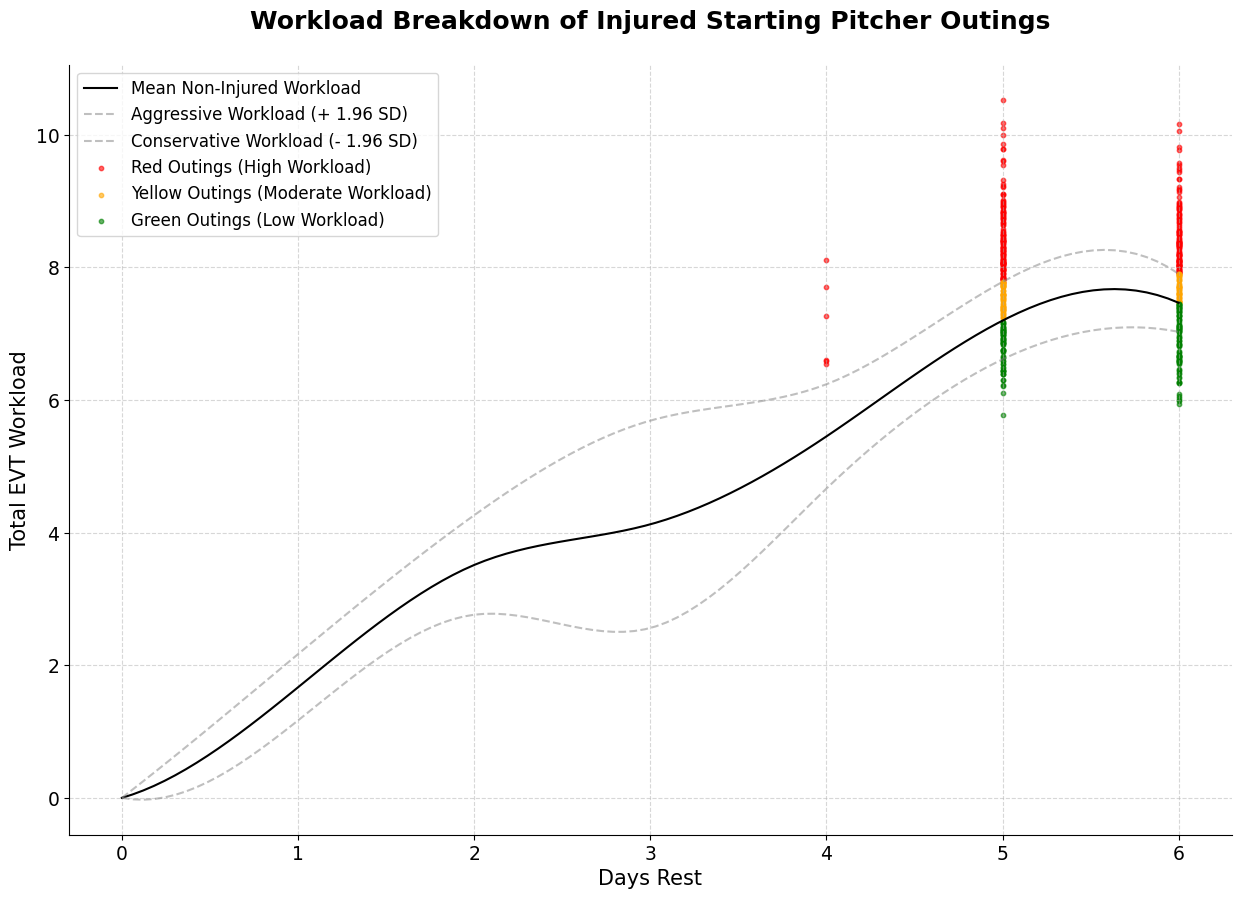

In [1194]:
# breakdown of outings from injured starting pitchers
    # TODO: add percentages to each day?
generate_workload_plot(
    total_workload_by_days_rest, 
    role='starter', 
    red_outings=red_outings['starter'],
    yellow_outings=yellow_outings['starter'],
    green_outings=green_outings['starter'],
    error_bars=False,
    title='Workload Breakdown of Injured Starting Pitcher Outings'
)

<Axes: title={'center': 'Workload Breakdown of Injured Relief Pitcher Outings\n'}, xlabel='Days Rest', ylabel='Total EVT Workload'>

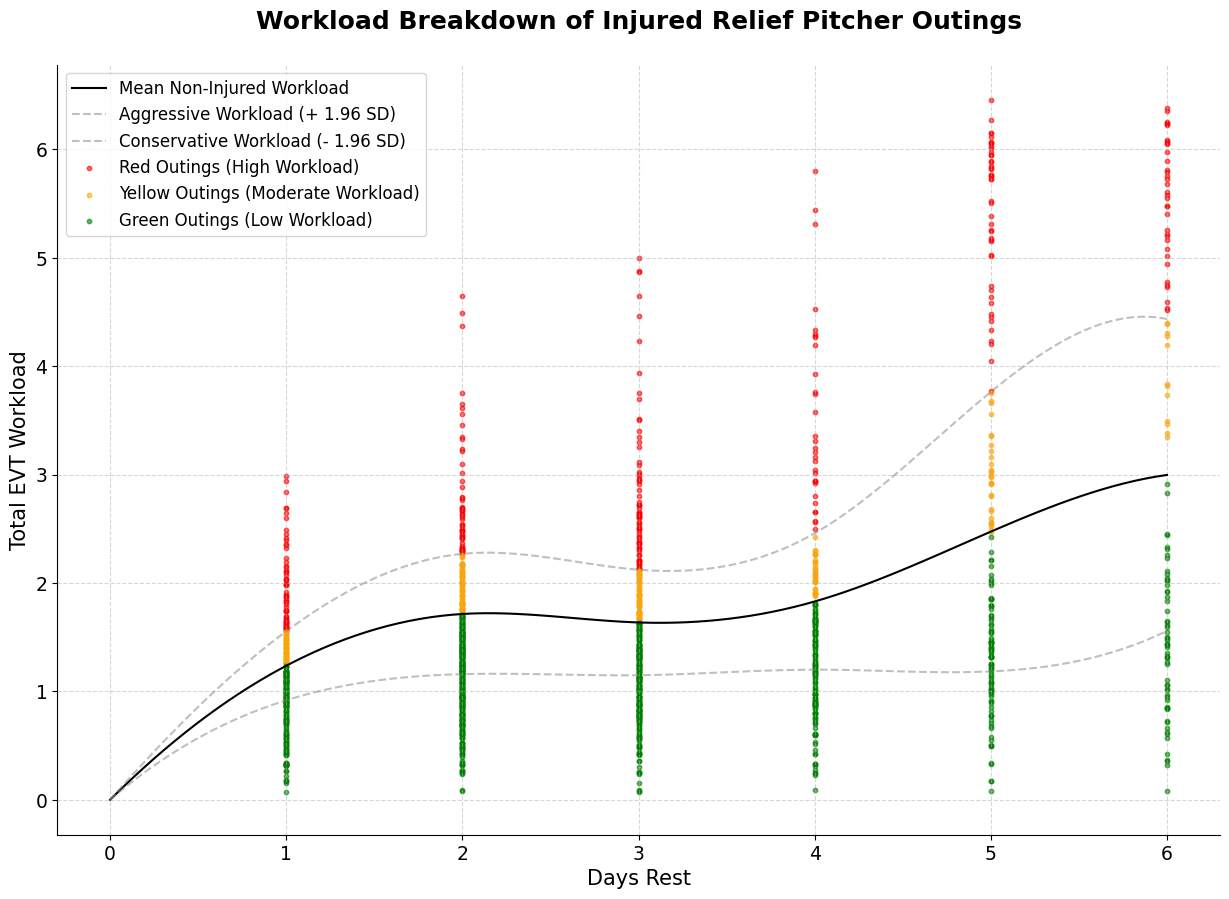

In [1195]:
# breakdown of outings from injured relief pitchers
    # TODO: add percentage to each day?
generate_workload_plot(
    total_workload_by_days_rest, 
    role='reliever', 
    red_outings=red_outings['reliever'],
    yellow_outings=yellow_outings['reliever'],
    green_outings=green_outings['reliever'],
    error_bars=False,
    title='Workload Breakdown of Injured Relief Pitcher Outings'
)

$\textbf{Outing(s) Prior to Injury}$

In [ ]:
def get_outing_types(df: pd.DataFrame) -> dict:
    """
    Returns dictionaries of red, yellow, and green outings for starters and relievers
    based on workload thresholds in the provided dataframe.

    Args:
        df (pd.DataFrame): DataFrame with columns:
            - outing_total_evt_workload
            - noninj_upper_bound
            - noninj_avg_workload
            - pitcher_role
            - pitcher_days_since_prev_game

    Returns:
        dict: red_outings, yellow_outings, green_outings
    """
    red_outings = {
        'starter': df[
            (df['outing_total_evt_workload'] > df['noninj_upper_bound']) &
            (df['pitcher_role'] == 'starter') &
            (df['pitcher_days_since_prev_game'] <= 6)
        ],
        'reliever': df[
            (df['outing_total_evt_workload'] > df['noninj_upper_bound']) &
            (df['pitcher_role'] == 'reliever') &
            (df['pitcher_days_since_prev_game'] <= 6)
        ]
    }
    yellow_outings = {
        'starter': df[
            (df['outing_total_evt_workload'] > df['noninj_avg_workload']) &
            (df['outing_total_evt_workload'] <= df['noninj_upper_bound']) &
            (df['pitcher_role'] == 'starter') &
            (df['pitcher_days_since_prev_game'] <= 6)
        ],
        'reliever': df[
            (df['outing_total_evt_workload'] > df['noninj_avg_workload']) &
            (df['outing_total_evt_workload'] <= df['noninj_upper_bound']) &
            (df['pitcher_role'] == 'reliever') &
            (df['pitcher_days_since_prev_game'] <= 6)
        ]
    }
    green_outings = {
        'starter': df[
            (df['outing_total_evt_workload'] <= df['noninj_avg_workload']) &
            (df['pitcher_role'] == 'starter') &
            (df['pitcher_days_since_prev_game'] <= 6)
        ],
        'reliever': df[
            (df['outing_total_evt_workload'] <= df['noninj_avg_workload']) &
            (df['pitcher_role'] == 'reliever') &
            (df['pitcher_days_since_prev_game'] <= 6)
        ]
    }
    
    return red_outings, yellow_outings, green_outings


In [1126]:
# filter to cohort used for analysis
cohort_ids = list(pd.concat([cohort_matches_final['mlbamid_injured'], cohort_matches_final['mlbamid_noninjured']]).unique())
outings_cohort = outing_metrics_clinical_bounds[outing_metrics_clinical_bounds['pitcher'].isin(cohort_ids)]

# get 1/2/3 outings prior to injury
inj_outing_prior = outings_cohort[outings_cohort['last_outing_before_injury'] == 1].copy()
inj_second_to_last = outings_cohort.groupby(['pitcher', 'season']).nth(-2)
inj_third_to_last = outings_cohort.groupby(['pitcher', 'season']).nth(-3)

# get outing types (red, yellow, green) for prior outings
red_outings_prior, yellow_outings_prior, green_outings_prior = get_outing_types(inj_outing_prior)
red_outings_2nd, yellow_outings_2nd, green_outings_2nd = get_outing_types(inj_second_to_last)
red_outings_3rd, yellow_outings_3rd, green_outings_3rd = get_outing_types(inj_third_to_last)

<Axes: title={'center': 'Workload Breakdown: Last Outing Prior to Injury (Starters)\n'}, xlabel='Days Rest', ylabel='Total EVT Workload'>

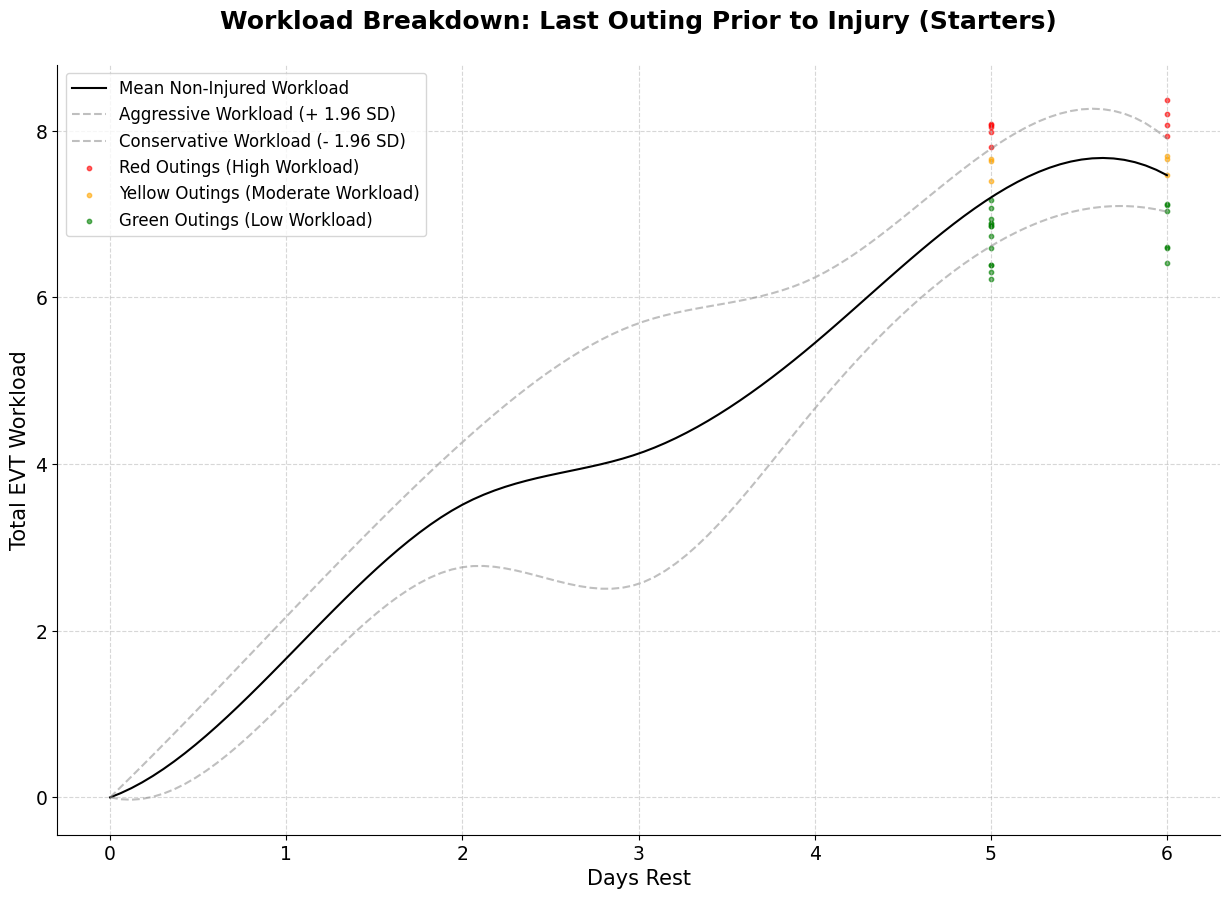

In [1199]:
generate_workload_plot(
    total_workload_by_days_rest, 
    role='starter', 
    red_outings=red_outings_prior['starter'],
    yellow_outings=yellow_outings_prior['starter'],
    green_outings=green_outings_prior['starter'],
    error_bars=False,
    title='Workload Breakdown: Last Outing Prior to Injury (Starters)'
)

$\textbf{Uploads}$

- TJ Cohort
- Pitch Level Metrics
- Outing Metrics

In [ ]:
# full cohort
aws.upload_to_s3(
    cohort_matches_final,
    'epidemiology/ml/datasets/full/cohort_matches_final.csv'
)

# pitch-level metrics
preds_cohort = model_preds_annotated[model_preds_annotated['pitcher'].isin(cohort_ids)]
aws.upload_to_s3(
    preds_cohort,
    'epidemiology/ml/datasets/preds/model_cohort.csv'
)

# outing metrics
aws.upload_to_s3(
    outing_metrics[outing_metrics['pitcher'].isin(cohort_ids)].merge(outing_metadata, on=['pitcher', 'season', 'game_date'], how='inner'),
    'epidemiology/ml/datasets/full/cohort_outing_metrics.csv'
)

[AWS]: Uploaded object to s3://pitch-ml/epidemiology/ml/datasets/full/cohort_matches_final.csv
[AWS]: Uploaded object to s3://pitch-ml/epidemiology/ml/datasets/preds/model_cohort.csv
[AWS]: Uploaded object to s3://pitch-ml/epidemiology/ml/datasets/full/cohort_outing_metrics.csv


$\textbf{Close AWS Connection}$

In [248]:
aws.close()

[AWS]: No active connection to close.
